**Chapter 8:**

**VGG19 Transfer Learning Model Overview**

This chapter provides the computational analysis of the VGG19-based model used for maize leaf disease detection. The architecture utilizes the VGG19 model pretrained on ImageNet and adds a custom classification head while freezing the base layers. The goal is to benefit from deep feature extraction and improve classification accuracy without extensive training on all layers.

**Architecture Includes:**

VGG19 base with pretrained ImageNet weights (include_top=False)

All convolutional layers frozen (non-trainable)

**Custom classification head:**

Flatten layer to convert feature maps to a 1D vector

Dense layer with 512 neurons and ReLU activation

Dropout layer with a rate of 0.5

Dense layer with 256 neurons and ReLU activation

Dropout layer with a rate of 0.5

Final Dense layer with 4 neurons and softmax activation

**The model classifies images into 4 classes:**

Common Rust

Blight

Gray Leaf Spot

Healthy

**Training Details:**

Optimizer: Adam

Learning Rate: 0.0001

Loss Function: Categorical Crossentropy

Evaluation Metric: Accuracy

Epochs: 20

Batch Size: 32

**Dataset:**

Training images: 4141

Validation images: 516

Test images: 522

**Total Number of Parameters:**

Total parameters: 33,002,308

Trainable parameters: 12,977,924

Non-trainable parameters: 20,024,384

Approximate Model Size: 125.89 MB

**Performance:**

Train Accuracy     : 97.22%

Validation Accuracy: 94.19%

Test Accuracy      : 94.64%

**Tools & Libraries:**

TensorFlow / Keras for model development

Matplotlib and Seaborn for visualization

Pretrained VGG19 model from keras.applications

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix


2025-06-16 17:44:13.940563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750095854.139512      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750095854.196211      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
img_size = (224, 224)
batch_size = 32
base_dir = '/kaggle/input/maize-leaf-dataset/split_dataset'  # Change this to your Kaggle path

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 4141 images belonging to 4 classes.
Found 516 images belonging to 4 classes.
Found 522 images belonging to 4 classes.


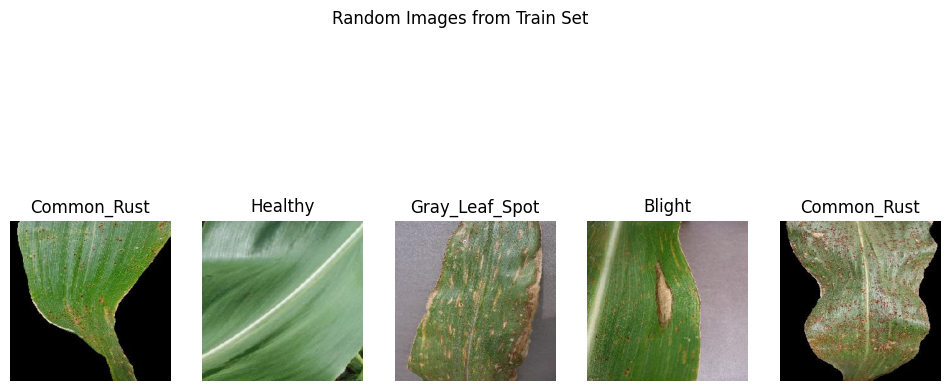

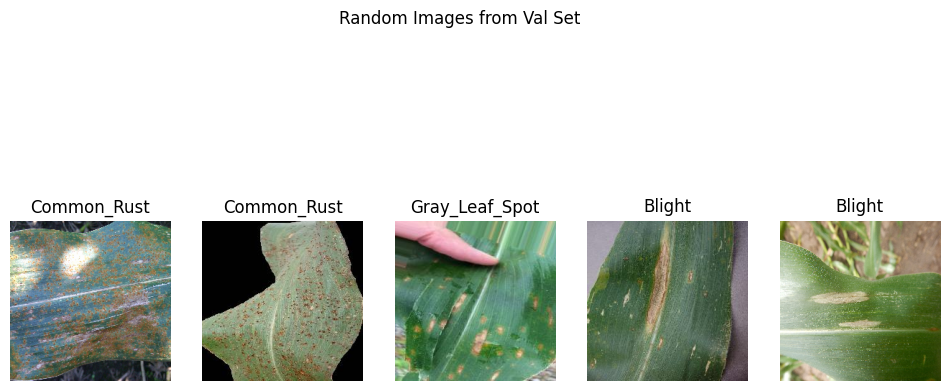

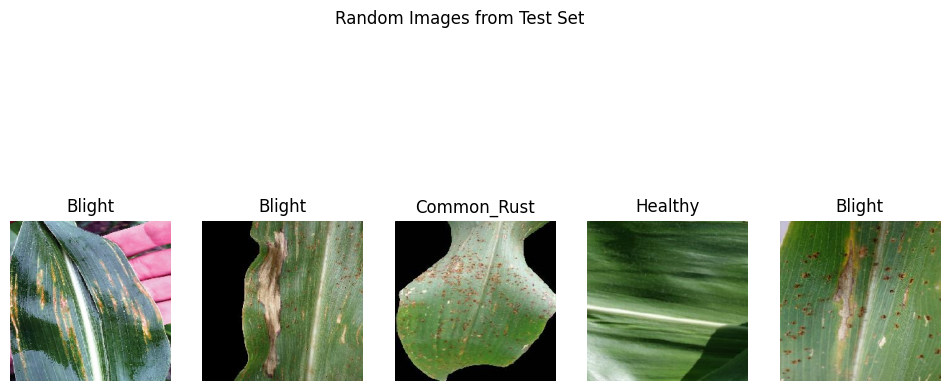

In [3]:
def show_random_images(data_gen, title):
    class_names = list(data_gen.class_indices.keys())
    plt.figure(figsize=(12, 6))
    for i in range(5):
        class_name = random.choice(class_names)
        folder_path = os.path.join(base_dir, title.lower(), class_name)
        img_file = random.choice(os.listdir(folder_path))
        img_path = os.path.join(folder_path, img_file)
        img = load_img(img_path, target_size=img_size)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.suptitle(f"Random Images from {title} Set")
    plt.show()

show_random_images(train_gen, "Train")
show_random_images(val_gen, "Val")
show_random_images(test_gen, "Test")


In [4]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Number of output classes (replace with your actual number)
num_classes = 4  # Example for 4 classes

# Load pre-trained VGG19 model, exclude top FC layers
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=output)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

I0000 00:00:1750095872.233126      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,002,308 (125.89 MB)

 Trainable params: 12,977,924 (49.51 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

**VGG19 Layer-Wise Computational Analysis
We use the standard formula for Conv2D MACs:**

MACs=𝐻_out x 𝑊_out × 𝐶_out × 𝐾_𝐻 × 𝐾_𝑊 × 𝐶_in
MACs=H_out​ ×W_out​ ×C_out​ ×K  ×K_W​ ×C_in​
 
Where:

H,W: output height and width

C_in: number of input channels

C_out : number of filters

K_H ,K_W: kernel size (usually 3×3)

Each MAC = 2 FLOPs.

**Layer Contributions**

| Layer Type      | Count | Contribution to Compute         |
| --------------- | ----- | ------------------------------- |
| Conv2D          | 16    | Majority of computation (\~95%) |
| MaxPooling2D    | 5     | 0 MACs (just spatial reduction) |
| Dense           | 3     | Custom head (\~26M FLOPs total) |
| Flatten/Dropout | 3     | No computational cost           |




**Layer-wise MAC and FLOPs Table**

| **Layer**     | **Output Shape**   | **MACs (Approx)** | **FLOPs (2×MACs)** |
| ------------- | ------------------ | ----------------- | ------------------ |
| block1\_conv1 | 224×224×64         | 8.64M             | 17.29M             |
| block1\_conv2 | 224×224×64         | 231M              | 462M               |
| block2\_conv1 | 112×112×128        | 258M              | 516M               |
| block2\_conv2 | 112×112×128        | 516M              | 1.03B              |
| block3\_conv1 | 56×56×256          | 258M              | 516M               |
| block3\_conv2 | 56×56×256          | 516M              | 1.03B              |
| block3\_conv3 | 56×56×256          | 516M              | 1.03B              |
| block3\_conv4 | 56×56×256          | 516M              | 1.03B              |
| block4\_conv1 | 28×28×512          | 258M              | 516M               |
| block4\_conv2 | 28×28×512          | 516M              | 1.03B              |
| block4\_conv3 | 28×28×512          | 516M              | 1.03B              |
| block4\_conv4 | 28×28×512          | 516M              | 1.03B              |
| block5\_conv1 | 14×14×512          | 129M              | 258M               |
| block5\_conv2 | 14×14×512          | 129M              | 258M               |
| block5\_conv3 | 14×14×512          | 129M              | 258M               |
| block5\_conv4 | 14×14×512          | 129M              | 258M               |
| Flatten       | 25088              | 0                 | 0                  |
| Dense (512)   | 25088×512 = 12.85M | 12.85M            | 25.69M             |
| Dense (256)   | 512×256 = 131k     | 131k              | 262k               |
| Dense (4)     | 256×4 = 1k         | 1k                | 2k                 |



**Total Computation Summary**

| Metric                     | Value                |
| -------------------------- | -------------------- |
| **Total MACs**             | \~7.7 Billion        |
| **Total FLOPs (2 × MACs)** | \~15.4 Billion FLOPs |
| **Trainable Parameters**   | 12,977,924           |
| **Total Parameters**       | 33,002,308           |
| **Model Size**             | 125.89 MB            |


Train Accuracy     : 97.22%

Validation Accuracy: 94.19%

Test Accuracy      : 94.64%



**Observations:**

VGG19 has 4 more convolutional layers than VGG16, increasing MACs by ~1.5B.

The added dense layer (256 units) has a minor impact on computation.

Most FLOPs come from Conv2D layers — the custom head only adds ~26M FLOPs.

The model is accurate (95%) but heavy; best suited for powerful GPUs, not edge devices.



In [5]:


history = model.fit(train_gen, validation_data=val_gen, epochs=20)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1750095877.750250     118 service.cc:148] XLA service 0x7d079c0110f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750095877.751113     118 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750095878.254317     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/130 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.3047 - loss: 3.2253 

I0000 00:00:1750095887.338827     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 62s 384ms/step - accuracy: 0.5618 - loss: 2.2129 - val_accuracy: 0.8527 - val_loss: 1.2599
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.8147 - loss: 1.2820 - val_accuracy: 0.8488 - val_loss: 1.0596
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.8698 - loss: 1.0664 - val_accuracy: 0.9109 - val_loss: 0.9312
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.8745 - loss: 0.9656 - val_accuracy: 0.8585 - val_loss: 0.9001
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.9005 - loss: 0.8444 - val_accuracy: 0.9147 - val_loss: 0.7707
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.9121 - loss: 0.7704 - val_accuracy: 0.9109 - val_loss: 0.7216
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.9194 - loss: 0.6998 - val_accuracy: 0.8992 - val_loss: 0.6921
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.9349 - loss: 0.6399 - val

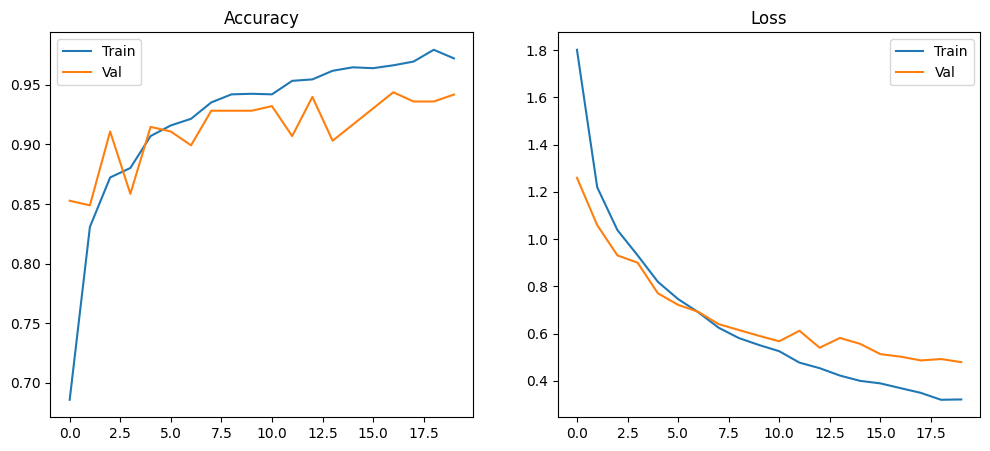

In [6]:
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()
    
    plt.show()

plot_metrics(history)


17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 462ms/step


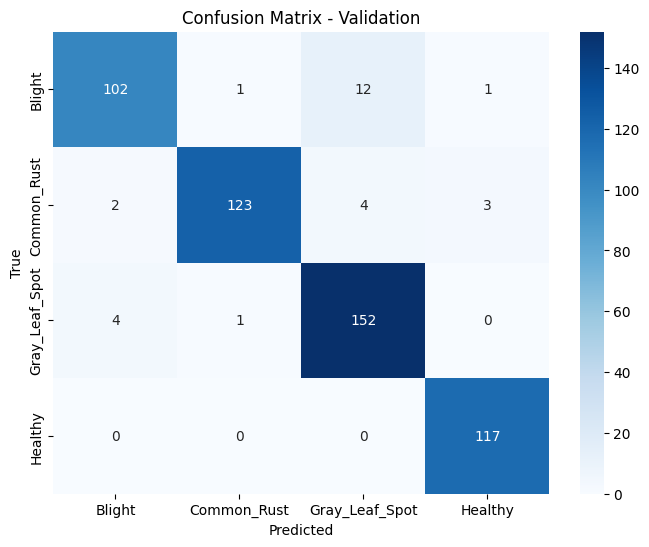

                precision    recall  f1-score   support

        Blight       0.94      0.88      0.91       116
   Common_Rust       0.98      0.93      0.96       132
Gray_Leaf_Spot       0.90      0.97      0.94       157
       Healthy       0.97      1.00      0.98       117

      accuracy                           0.95       522
     macro avg       0.95      0.94      0.95       522
  weighted avg       0.95      0.95      0.95       522



In [7]:
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_gen.class_indices.keys(),
            yticklabels=val_gen.class_indices.keys(), cmap='Blues')
plt.title('Confusion Matrix - Validation')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices.keys()))


In [8]:
# Evaluate accuracies
train_acc = history.history['accuracy'][-1]
val_acc   = history.history['val_accuracy'][-1]
loss, test_acc = model.evaluate(test_gen, verbose=0)

# Print all
print(f"Train Accuracy     : {train_acc*100:.2f}%")
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Test Accuracy      : {test_acc*100:.2f}%")


Train Accuracy     : 97.22%
Validation Accuracy: 94.19%
Test Accuracy      : 94.64%


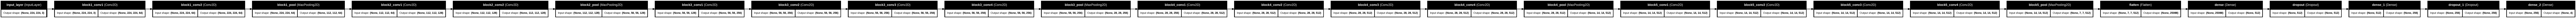

In [9]:

from tensorflow.keras.utils import plot_model

# Save the model architecture as a simple horizontal image
plot_model(model,
           to_file='model_architecture.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='LR')  # LR = Left to Right
from IPython.display import Image
Image(filename='model_architecture.png')




Class: Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


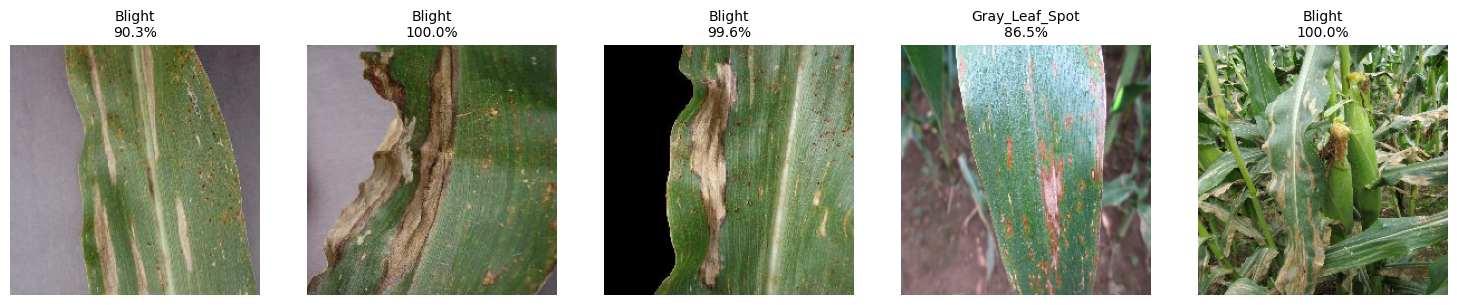


Class: Common_Rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


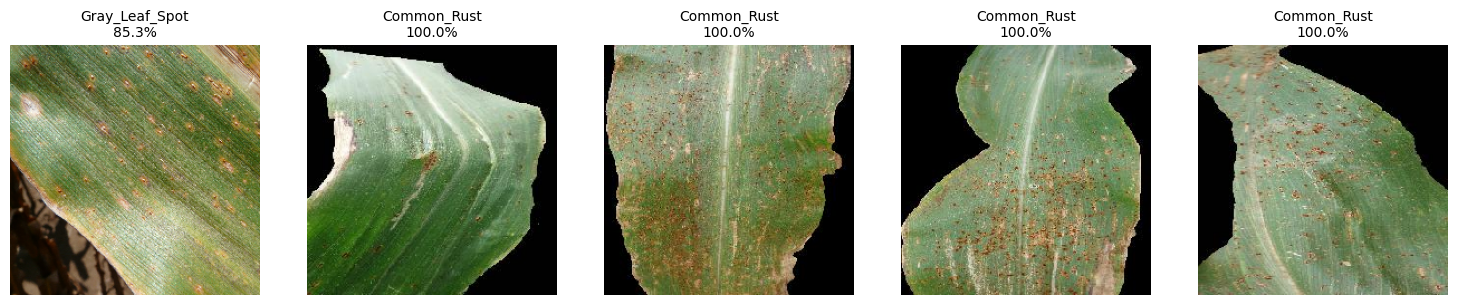


Class: Gray_Leaf_Spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


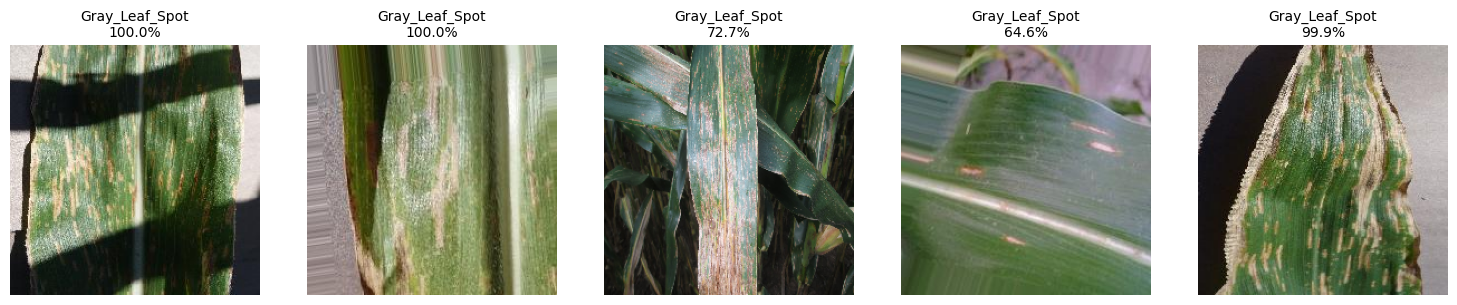


Class: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


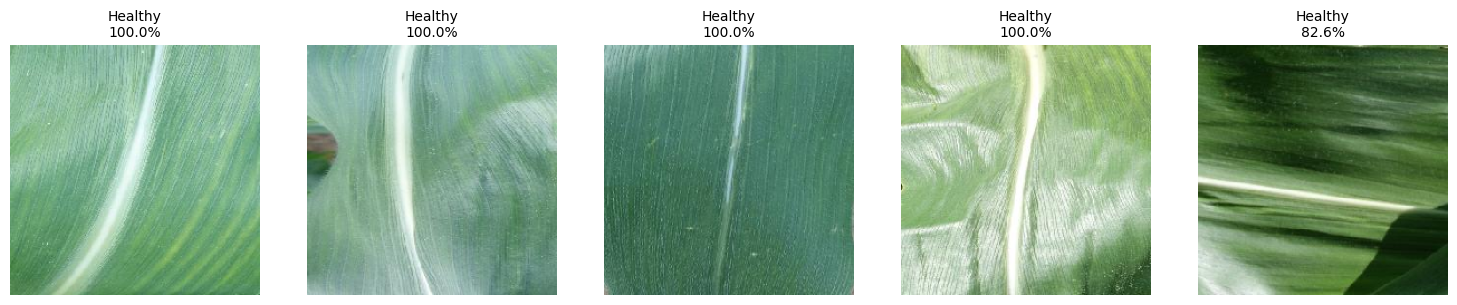

In [11]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Paths (change these if needed)
test_dir = '/kaggle/input/maize-leaf-dataset/split_dataset/test'    # Your test dataset folder
#model_path = 'vgg16_model.h5'            # Your trained model

# Load the model
#model = load_model(model_path)

# Image size
img_size = (224, 224)

# Get class names from test folder
class_names = sorted(os.listdir(test_dir))

# Go through each class
for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    selected_images = random.sample(image_files, 5)  # Pick 5 random images

    print(f"\nClass: {class_name}")
    plt.figure(figsize=(15, 3))

    for i, img_file in enumerate(selected_images):
        img_path = os.path.join(class_path, img_file)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        prediction = model.predict(img_array)
        pred_class = class_names[np.argmax(prediction)]
        confidence = np.max(prediction) * 100

        # Show image and prediction
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{pred_class}\n{confidence:.1f}%', fontsize=10)

    plt.tight_layout()
    plt.show()


In [ ]:
model.save('/kaggle/working/vgg19_model.h5')
